# DO NOT Change book_data.csv from this Jupyter Notebook - Caleb of the Past

There are no safety mechanisms in here and you might overwrite all the data in the csv... I should probably back this up somewhere. Ah, well... A problem for future Caleb.

In [2]:
import os
import string

from IPython.display import clear_output, display
from distinctipy import distinctipy # For distinct cmaps

import matplotlib
import matplotlib.pyplot as plt
import mplcursors
matplotlib.use('Qt5Agg')

from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import numpy as np
import pandas as pd

from gensim.models import Word2Vec, TfidfModel
from gensim.corpora import Dictionary

# Trying out both.
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def load_data_with_header(csv_path):
    df = pd.read_csv(csv_path)
    return df

books = load_data_with_header("./data/book_data.csv")
books['text'] = books.apply(lambda row: f"Author: {row['Author']}\n Genres: {row['Genres']}\n Blurb: {row['Blurb']}", axis=1)
books = books.convert_dtypes()
display(books.columns)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caleb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Index(['URL_ID', 'Author', 'Title', 'Genres', 'Blurb', 'Average Rating',
       'My Rating', 'text'],
      dtype='object')

# Break books out into groups by rating

In [22]:
# Calculate the number of bins
# bin_width = 25
# rating_min = books['Average Rating'].min()
# rating_max = books['Average Rating'].max()
# bins = np.linspace(rating_min, rating_max)

# books['Average Rating'].plot(kind='hist', bins=bins, edgecolor='black', alpha=0.7)
# display(rating_min)
# display(rating_max)
# plt.xlabel('Average Ratings')
# plt.ylabel('Frequency')
# plt.title('Histogram of book ratings')
# plt.show()

In [26]:
# Replace Books with the top quartile
sorted_books = books.sort_values(by='Average Rating', ascending=False)

top_fraction = len(sorted_books) // 4
top_books = sorted_books.head(top_fraction)
display(top_fraction)
top_books

11390

,URL_ID,Author,Title,Genres,Blurb,Average Rating,My Rating,text
1620,62036128,Mag Gabbert,Sex Depression Animals: Poems,Poetry,"In SEX DEPRESSION ANIMALS, Mag Gabbert redefin...",500,0,Author: Mag Gabbert Genres: Poetry Blurb: In...
2400,60176846,Spica Aoki,乙女怪獣キャラメリゼ 7 [Otome Kaijuu Caraméliser 7] (Kai...,Manga,はるか遠く未開の島で、黒絵は自身の誕生の秘密を知る――。大怪獣「ハルゴン」へと変貌する女子高...,500,0,Author: Spica Aoki Genres: Manga Blurb: はるか遠...
2797,60398329,Sammi Katz,Cocktails in Color: A Spirited Guide to the Ar...,Food Nonfiction Cookbooks,An artistic cocktail book that is as beautiful...,500,0,Author: Sammi Katz Genres: Food Nonfiction Co...
244,122767274,Kirsten L. Marie,Rhyme of the Aged Hummingbird (Nature's Li'l S...,Nonfiction,Second book in the Nature’s Li’l Samaritans se...,500,0,Author: Kirsten L. Marie Genres: Nonfiction ...
920,61830194,Grace Draven,"Black Hellebore (Wraith Kings, #3.1)",Fantasy Romance Fantasy Romance Short Stories,**The love story of Brishen and Ildiko continu...,500,0,Author: Grace Draven Genres: Fantasy Romance ...
...,...,...,...,...,...,...,...,...
29688,36746758,Drew Hunter,Made for Friendship: The Relationship That Hal...,Christian Christian Living Nonfiction Relation...,"While most people have companions, acquaintanc...",429,0,Author: Drew Hunter Genres: Christian Christi...
6260,42112733,Robert Crais,"A Dangerous Man (Elvis Cole, #18; Joe Pike, #7)",Mystery Fiction Thriller Crime Suspense Myster...,"A brilliant new crime novel from the beloved, ...",429,0,Author: Robert Crais Genres: Mystery Fiction ...
32153,60286104,João Reis,Cadernos da Água,Portugal Portuguese Literature,A realidade que estamos habituados a ver à dis...,429,0,Author: João Reis Genres: Portugal Portuguese...
35763,40537277,Lorraine Cink,Powers of a Girl: 65 Marvel Women Who Punched ...,Marvel Graphic Novels Comics Young Adult Super...,Named one of the New York Public Library's Bes...,429,0,Author: Lorraine Cink Genres: Marvel Graphic ...


Optional: Overwrite the ratings.csv with the values in book_data.csv

In [27]:
# result = [(row['URL_ID'], row['My Rating']) for _, row in books.iterrows() if row['My Rating'] > 0]

# df = pd.DataFrame(result, columns=["UID", "My Rating"])
# df = df.convert_dtypes()
# df.to_csv("./data/ratings.csv", index=False)

In [28]:
words_to_drop = ['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that', 'he', 'was', 'for', 'on', 'are', 'with', 'as', 'I', 'his', 'they', 'be', 'at', 'one', 'have', 'this', 'from', 'or', 'had', 'by', 'not', 'word', 'but', 'what', 'some', 'we', 'can', 'out', 'other', 'were', 'all', 'there', 'when', 'up', 'use', 'your', 'how', 'said', 'an', 'each', 'she', 'which', 'do', 'their', 'time', 'if', 'will', 'way', 'about', 'many', 'then', 'them', 'write', 'would', 'like', 'so', 'these', 'her', 'long', 'make', 'thing', 'see', 'him', 'two', 'has', 'look', 'more', 'day', 'could', 'go', 'come', 'did', 'number', 'sound', 'no', 'most', 'people', 'my', 'over', 'know']

## TODO(Break up into better tokens since Japanese doesn't have spaces.)

In [29]:
language_map = {
    'cs': 'czech',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'et': 'estonian',
    'fi': 'finnish',
    'fr': 'french',
    'de': 'german',
    'el': 'greek',
    'it': 'italian',
    'no': 'norwegian',
    'pl': 'polish',
    'pt': 'portuguese',
    'ru': 'russian',
    'sl': 'slovene',
    'es': 'spanish',
    'sv': 'swedish',
    'tr': 'turkish',
}

We happen to know that there are manga in the dataset, which has Japanese; so, we allow that to be tokenized as well

In [30]:
import fugashi

# This is our sample text.
# "Fugashi" is a Japanese snack primarily made of gluten.
text = "麩菓子は、麩を主材料とした日本の菓子。"

# The Tagger object holds state about the dictionary. 
tagger = fugashi.Tagger()

words = [word.surface for word in tagger(text)]
print(*words)
# => 麩 菓子 は 、 麩 を 主材 料 と し た 日本 の 菓子 。

麩 菓子 は 、 麩 を 主材 料 と し た 日本 の 菓子 。


In [31]:
failed_langs = set()

# The Tagger object holds state about the Japanese dictionary. 
tagger = fugashi.Tagger()


def tokenize_by_lang(l):
    tokenizations = []
    for text in l:
        lang = detect(text)
        text = "".join([char for char in list(text) if char not in string.punctuation])
        text = " ".join([x.strip().lower() for x in text.split(" ")])
        text = " ".join([x for x in text.split(" ") if x not in stop_words and len(x.strip()) != 1 and x not in words_to_drop])
        # print(text)
        if lang in language_map:
            tokenizations.append([x for x in word_tokenize(text, language=language_map[lang]) if x not in stop_words and len(x.strip()) != 1])
        elif lang == 'ja':
             tokenizations.append([word.surface for word in tagger(text)])
        else:
            if lang not in failed_langs: # Don't print every time -- just every language.
                print(f"Tried to tokenize: {lang} and failed. Defaulting to English tokenization >.<.")
                failed_langs.add(lang)
            tokenizations.append(word_tokenize(text))
    return tokenizations

print(tokenize_by_lang(["testing, For for  djiasodjisa823u18rj9201rj   the and know  I one two three the and nope"]))
print(tokenize_by_lang(["麩菓子は、麩を主材料とした日本の菓子。"]))

[['testing', 'djiasodjisa823u18rj9201rj', 'three', 'nope']]
[['麩', '菓子', 'は', '、', '麩', 'を', '主材', '料', 'と', 'し', 'た', '日本', 'の', '菓子', '。']]


# Note which df you are generating from! (Might be the top quartile or otherwise.)

In [32]:
# Easily replace books by other dfs
# df_of_interest = books
df_of_interest = top_books

sentences = tokenize_by_lang(df_of_interest['text'].tolist())
embedding_size = 150 # The internet is vague and says "a number between 100 and 1000 is pretty good or something"
e = 150
print(f"Starting word2vec training for {e} epochs...")
word2vec = Word2Vec(sentences, vector_size=embedding_size, min_count=2, window=7, epochs=e)

dictionary = Dictionary(sentences)
corpus = [dictionary.doc2bow(sentence) for sentence in sentences]

print(f"Starting to train TfidfModel on the corpus of size {len(corpus)}")
# Train a Gensim TF-IDF model using the corpus
tfidf = TfidfModel(corpus)

def sentence_embedding(sentence, model, tfidf_model, dictionary):
    words = tokenize_by_lang([sentence])[0]
    assert(type(words) == list)
    word_embeddings = []
    
    for word in words:
        if word == '':
            continue
        if word in model.wv:
            # print(f"Word '{word}' found in word2vec model")
            bow = dictionary.doc2bow([word])
            if len(bow) > 0:
                # print(f"Word '{word}' found in dictionary with ID {bow[0][0]}")
                tfidf_weights = tfidf_model[bow]
                if len(tfidf_weights) > 0:
                    tfidf_weight = tfidf_weights[0][1]
                    word_embeddings.append(model.wv[word] * tfidf_weight)
                    # print(f"Word '{word}' added to embeddings with TF-IDF weight {tfidf_weight}")
                else:
                    if word not in ["blurb", "author", "genres", ":"]:
                        print(f"No TF-IDF weights found for word '{word}'")
            else:
                print(f"Word '{word}' not found in dictionary")
        else:
            print(f"Word '{word}' not found in word2vec model")
    
    if len(word_embeddings) > 0:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

print(f"Length of dictionary: {len(dictionary)}")
print(f"Length of corpus: {len(corpus)}")
embeddings = np.array([sentence_embedding(text, word2vec, tfidf, dictionary) for text in df_of_interest['text']])

Tried to tokenize: ko and failed. Defaulting to English tokenization >.<.
Tried to tokenize: ro and failed. Defaulting to English tokenization >.<.
Tried to tokenize: uk and failed. Defaulting to English tokenization >.<.
Tried to tokenize: id and failed. Defaulting to English tokenization >.<.
Tried to tokenize: bg and failed. Defaulting to English tokenization >.<.
Tried to tokenize: hu and failed. Defaulting to English tokenization >.<.
Tried to tokenize: vi and failed. Defaulting to English tokenization >.<.
Tried to tokenize: ca and failed. Defaulting to English tokenization >.<.
Tried to tokenize: sk and failed. Defaulting to English tokenization >.<.
Tried to tokenize: ar and failed. Defaulting to English tokenization >.<.
Tried to tokenize: th and failed. Defaulting to English tokenization >.<.
Tried to tokenize: lv and failed. Defaulting to English tokenization >.<.
Tried to tokenize: zh-tw and failed. Defaulting to English tokenization >.<.
Tried to tokenize: bn and failed. D

In [33]:
len(sentences)

11390

## Index needs to be dropped from top books to not have OOR error

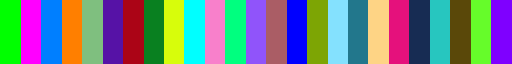

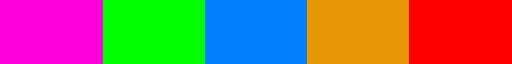

C:\Users\caleb\AppData\Local\Temp\ipykernel_14076\918198114.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_of_interest['cluster'] = cluster_labels


IndexError: index 39278 is out of bounds for axis 0 with size 11390

In [34]:
# Cluster the embeddings
# n_clusters = 25
# kmeans = KMeans(n_clusters=n_clusters,n_init='auto')
# cluster_labels = kmeans.fit_predict(embeddings)

# Instantiate the GMM object
n_clusters = 25
gmm = GaussianMixture(n_components=n_clusters)

# Fit the GMM model to the data
gmm.fit(embeddings)

# Predict the cluster labels for the data
cluster_labels = gmm.predict(embeddings)

# generate n_clusters many visually distinct colours
colors = distinctipy.get_colors(n_clusters)
cluster_color_cmap = distinctipy.get_colormap(colors, name='cluster')
display(cluster_color_cmap)

# ratings always go from 1 to 5.
rating_colors = distinctipy.get_colors(5)
rating_color_cmap = distinctipy.get_colormap(rating_colors, name='ratings')
display(rating_color_cmap)

df_of_interest['cluster'] = cluster_labels

def closest_words_to_vector(model, vector, n=5):
    return model.wv.similar_by_vector(vector, topn=n)

cluster_mean_embeddings = []
for i in range(n_clusters):
    cluster_books = df_of_interest[df_of_interest['cluster'] == i]
    mean_embedding = np.mean(embeddings[cluster_books.index], axis=0)
    cluster_mean_embeddings.append(mean_embedding)

n_closest_words = 4
cluster_closest_words = [closest_words_to_vector(word2vec, mean_embedding, n=n_closest_words) for mean_embedding in cluster_mean_embeddings]

text_cluster_labels = [" ".join([word for word, _ in closest_words if len(word.strip().lower()) > 1]) for closest_words in cluster_closest_words]
for cl in text_cluster_labels:
    print(cl)

In [ ]:
# Collect ratings from the user
n_books_to_rate = 0

# Save user ratings using pandas
def save_user_ratings(user_ratings):
    ratings_df = pd.DataFrame(user_ratings, columns=['UID', 'My Rating'])
    ratings_df.to_csv(ratings_file, index=False)

# Load user ratings using pandas
def load_user_ratings():
    user_ratings = {}
    if os.path.exists(ratings_file) and os.path.getsize(ratings_file) > 0:
        ratings_df = pd.read_csv(ratings_file)
        user_ratings = pd.read_csv("./data/ratings.csv")
    return user_ratings.values.tolist()

# Function to present a profile to the user and collect their rating
def present_book_and_rate(df, cluster, rating_uids):
    clear_output(wait=True)
    while True: 
        sample = df[df['cluster'] == cluster].sample(1).iloc[0]
        if sample['URL_ID'] not in rating_uids:
            break
    display(sample['Blurb']) # Should I present more than just the blurb?
    rating = int(input("Please rate this book blurb from 1 to 5: "))
    return sample['URL_ID'], rating

ratings_file = './data/ratings.csv'

# Load previously saved user ratings
user_ratings = load_user_ratings()
# print(user_ratings)

uids = set()
for u in user_ratings:
    uids.add(u[0])

for i in range(n_books_to_rate):
    cluster = np.random.randint(0, n_clusters)
    uid, rating = present_book_and_rate(df_of_interest, cluster, uids)
    user_ratings.append([uid, rating])

# Save the updated user ratings
save_user_ratings(user_ratings)

In [ ]:
# Prepare the dataset for training the rating prediction model
# Update the "My Rating" column based on the list of pairs
for uid, r in user_ratings:
    df_of_interest.loc[df_of_interest['URL_ID'] == uid, 'My Rating'] = r

train_data, test_data = train_test_split(df_of_interest[df_of_interest['My Rating'] > 0], test_size=0.3, random_state=42)

X_train = embeddings[train_data.index]
y_train = train_data['My Rating']

X_test = embeddings[test_data.index]
y_test = test_data['My Rating']

# Train a Ridge regression model to predict user ratings
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

# Evaluate the model
y_pred = ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

# Predict ratings for all profiles in the dataset
df_of_interest['predicted_rating'] = ridge.predict(embeddings)

Mean squared error: 0.904103891655225


In [35]:
# Apply t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

# The coloring is wrong for some reason-- not coloring by cluster appropriately

In [36]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import mplcursors

col_to_color = {"My Rating": rating_color_cmap, "cluster": cluster_color_cmap}

def get_text_color(bg_color):
    r, g, b, _ = bg_color
    luminance = (0.299 * r + 0.587 * g + 0.114 * b)
    return 'white' if luminance < 0.5 else 'black'

# Function to update the scatter plot
def update_scatter(ax, fig, coloring_column: str):
    scatter = ax.collections[0]  # Access the scatter object via ax
    scatter.set_array(np.array(df_of_interest[coloring_column], dtype=float))
    fig.canvas.draw_idle()

# Button click event handler
def on_click(ax, fig):
    global coloring_by_cluster
    coloring_by_cluster = not coloring_by_cluster
    coloring_column = 'cluster' if coloring_by_cluster else 'My Rating'
    update_scatter(ax, fig, coloring_column)
    button.label.set_text(f"Color by {'My Rating' if coloring_by_cluster else 'cluster'}")
    fig.canvas.draw_idle()

def plot_embeddings(coloring_column, alpha=0.5):
    # Plot the 2D embeddings with labels
    plt.rcParams['font.family'] = 'Kiwi Maru'
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_of_interest[coloring_column].astype(float), cmap=col_to_color[coloring_column], alpha=alpha)
    
    label_dict = {}
    annotation_color = {}
    for idx, row in df_of_interest.iterrows():
        suffix = ":: " + str(row['My Rating']) + "/5"
        if suffix == '0':
            suffix = ' unread'
            annotation_color[idx] = 'gray'
        else:
            annotation_color[idx] = plt.get_cmap(col_to_color[coloring_column])(row[coloring_column] / df_of_interest[coloring_column].max())
        
        label_dict[idx] = str(row['Title'] + suffix)

    def label_func(index):
        return label_dict.get(index, '')

    def annotation_color_func(index):
        return annotation_color.get(index, 'black')

    # Add interactive labels when hovering over points
    cursor = mplcursors.cursor(scatter, hover=True)
    cursor.connect('add', lambda sel: (sel.annotation.get_bbox_patch().set(fc=annotation_color_func(sel.index), alpha=1),
                                       sel.annotation.set_color(get_text_color(annotation_color_func(sel.index))),
                                       sel.annotation.set_text(label_func(sel.index))))
    
    cluster_and_embeddings_2d = df_of_interest[['cluster']].copy()
    cluster_and_embeddings_2d['x'] = embeddings_2d[:, 0]
    cluster_and_embeddings_2d['y'] = embeddings_2d[:, 1]
    
    mean_2d_positions = cluster_and_embeddings_2d.groupby('cluster').mean()
    
    for label in df_of_interest['cluster'].unique():
        color = col_to_color['cluster'](label)  # get color for cluster label
        text = text_cluster_labels[label]  # get cluster label text
        bbox = dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.2')  # create bbox with facecolor
        ax.annotate(text, mean_2d_positions.loc[label], fontsize=8, ha='center', va='center', bbox=bbox)  # annotate with bbox
    # for i, (x, y) in mean_2d_positions.iterrows():
    #     ax.annotate(text_cluster_labels[i], (x, y), fontsize=8, ha='center', va='center', bbox=dict(facecolor=cluster_color_cmap, edgecolor='black', boxstyle='round,pad=0.2'))

    # Set plot title and axis labels
    ax.set_title(f"2D Visualization of Data with Labels (Colored by {coloring_column})")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")

    # Create and position the button
    button_ax = plt.axes([0.85, 0.025, 0.12, 0.04])  # x, y, width, height
    button = Button(button_ax, f"Color by {'My Rating' if coloring_by_cluster else 'Cluster'}")
    
    # Connect the button to the on_click function
    def button_on_click(event):
        on_click(ax, fig)

    button.on_clicked(button_on_click)
    
    return button, fig, ax

# Initial plot
coloring_by_cluster = True
if coloring_by_cluster:
    button, fig, ax = plot_embeddings('cluster', 0.3)
else:
    button, fig, ax = plot_embeddings('My Rating', 0.3)
plt.show()


NameError: name 'text_cluster_labels' is not defined

In [ ]:
import matplotlib
print(matplotlib.get_cachedir())
